In [8]:
import sys
import os
import subprocess
import shutil
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import seawater
import gsw

from datetime import datetime, timedelta, date


sys.path.append('../sdpm_py_util')
import init_funs_forecast as initfuns
import run_funs as runfuns
sys.path.append('/home/mspydell/models/PFM_root/PFM/driver')
import driver_functions as driverfuns
#from driver_run_forecast_LV1234 import driver_run_fore_LV1234
from driver_run_pfm_phm import driver_run_pfm_phm


In [13]:
fn = '/projects/www-users/falk/PFM_Forecast/LV4_His/web_data_latest.nc'
ds = nc.Dataset(fn)
print(ds.variables.keys())
print(ds.variables['time'])
t = ds.variables['time'][:]
print(t[0:2])

t0 = datetime(1999,1,1)
t2 = t0 + t*timedelta(days=1)
print(t2[0])
print(t2[1])




dict_keys(['shoreline_dye_tot', 'shoreline_risk', 'map_dye_tot', 'sites_dye_tot', 'sites_risk', 'shoreline_l10_dye_tot', 'map_l10_dye_tot', 'sites_l10_dye_tot', 'map_lat', 'map_lon', 'shoreline_lat', 'shoreline_lon', 'time', 'sites_lat', 'sites_lon', 'thresh_holds'])
<class 'netCDF4.Variable'>
float64 time(ntime)
    _FillValue: nan
    long_name: time in days past Jan 1, 1999
    units: days
unlimited dimensions: 
current shape = (121,)
filling on
[9694.         9694.04166667]
2025-07-17 00:00:00
2025-07-17 01:00:00


In [2]:
#pkl_fnm = '/scratch/matt/PFM_Simulations_v2/forecast_info.pkl'
pkl_fnm = '/scratch/PFM_Simulations/forecast_info.pkl'

MI = initfuns.get_model_info( pkl_fnm)
fn_hs = MI['lv4_his_name_full']
fn_gr = MI['lv4_grid_file']
cmd_list = ['python','-W','ignore','web_functions.py','full_his_to_essential',fn_hs,fn_gr,pkl_fnm]
os.chdir('../web_util')
ret6 = subprocess.run(cmd_list)   
print('...done making web nc file: ' + str(ret6.returncode) + ' (0=good)')  
os.chdir('../driver')


...done making web nc file: 0 (0=good)


In [4]:
dt_plotting = []
print('now making all of the plots for the entire simulation...')
t01 = datetime.now()

print('making LV1 history file plots and moving on (Popen)...')
cmd_list = ['python','-W','ignore','plotting_functions.py','make_all_his_figures','LV1',pkl_fnm]
os.chdir('../sdpm_py_util')
pr1 = subprocess.Popen(cmd_list)   

print('making LV2 history file plots and moving on (Popen)...')
cmd_list = ['python','-W','ignore','plotting_functions.py','make_all_his_figures','LV2',pkl_fnm]
pr2 = subprocess.Popen(cmd_list)   

print('making LV3 history file plots and moving on (Popen)...')
cmd_list = ['python','-W','ignore','plotting_functions.py','make_all_his_figures','LV3',pkl_fnm]
pr3 = subprocess.Popen(cmd_list)   

print('making LV4 history file plots and moving on (Popen)...')
t01=datetime.now()
cmd_list = ['python','-W','ignore','plotting_functions.py','make_all_his_figures','LV4',pkl_fnm]
pr4 = subprocess.Popen(cmd_list)   

print('doing LV4 dye plots and waiting (Popen)...')
fn_gr = MI['lv4_grid_file']
fn_hs = MI['lv4_his_name_full']
cmd_list = ['python','-W','ignore','plotting_functions.py','make_dye_plots',fn_gr,fn_hs,pkl_fnm]
pr5 = subprocess.Popen(cmd_list)   

print('waiting for plotting to finish...')
exit_codes = []
for pr in [pr1,pr2,pr3,pr4,pr5]:
    exit_codes.append(pr.wait()) # this waits for pr1...pr5 to finish

t02 = datetime.now()
dt_plotting.append(t02-t01)
print('...done waiting.')
print('plotting took:')
print(t02-t01)
print('LV1 history plots made correctly: ',exit_codes[0],' (0=yes)')
print('LV2 history plots made correctly: ',exit_codes[1],' (0=yes)')
print('LV3 history plots made correctly: ',exit_codes[2],' (0=yes)')
print('LV4 history plots made correctly: ',exit_codes[3],' (0=yes)')
print('LV4 dye     plots made correctly: ',exit_codes[4],' (0=yes)')


now making all of the plots for the entire simulation...
making LV1 history file plots and moving on (Popen)...
making LV2 history file plots and moving on (Popen)...
making LV3 history file plots and moving on (Popen)...
making LV4 history file plots and moving on (Popen)...
doing LV4 dye plots and waiting (Popen)...
waiting for plotting to finish...
getting clims...
getting clims...
getting clims...
...done.
...done.
...done.
getting clims...
...done.
...done waiting.
plotting took:
0:19:40.340374
LV1 history plots made correctly:  0  (0=yes)
LV2 history plots made correctly:  0  (0=yes)
LV3 history plots made correctly:  0  (0=yes)
LV4 history plots made correctly:  0  (0=yes)
LV4 dye     plots made correctly:  0  (0=yes)


In [ ]:

driverfuns.run_fore_LV4(pkl_fnm)

In [ ]:
nt  = 2
nz  = 3
nlt = 4
nln = 5
salt = 32 + np.ones((nt,nz,nlt,nln))
temp = 2 + np.ones((nt,nz,nlt,nln))
pdb = 0*salt
for a in np.arange(nz):
    pdb[:,a,:,:] = 1000*(a-1) + 1
    
ptemp = 0*temp
ptemp[0,:,:,:] = seawater.ptmp(np.squeeze(salt[0,:,:,:]), np.squeeze(temp[0,:,:,:]),np.squeeze(pdb[0,:,:,:]))
print(ptemp[0,:,:,:])
#print(ptemp[0,:,:,:]-temp[0,:,:,:])

ptemp2 = 0*temp
ptemp2[0,:,:,:] = gsw.pt_from_t(np.squeeze(salt[0,:,:,:]), np.squeeze(temp[0,:,:,:]),np.squeeze(pdb[0,:,:,:]),0)
print(ptemp2[0,:,:,:])
print(ptemp2[0,:,:,:]-ptemp[0,:,:,:])


[[[3.04876502 3.04876502 3.04876502 3.04876502 3.04876502]
  [3.04876502 3.04876502 3.04876502 3.04876502 3.04876502]
  [3.04876502 3.04876502 3.04876502 3.04876502 3.04876502]
  [3.04876502 3.04876502 3.04876502 3.04876502 3.04876502]]

 [[2.99994275 2.99994275 2.99994275 2.99994275 2.99994275]
  [2.99994275 2.99994275 2.99994275 2.99994275 2.99994275]
  [2.99994275 2.99994275 2.99994275 2.99994275 2.99994275]
  [2.99994275 2.99994275 2.99994275 2.99994275 2.99994275]]

 [[2.9345975  2.9345975  2.9345975  2.9345975  2.9345975 ]
  [2.9345975  2.9345975  2.9345975  2.9345975  2.9345975 ]
  [2.9345975  2.9345975  2.9345975  2.9345975  2.9345975 ]
  [2.9345975  2.9345975  2.9345975  2.9345975  2.9345975 ]]]
[[[3.04842826 3.04842826 3.04842826 3.04842826 3.04842826]
  [3.04842826 3.04842826 3.04842826 3.04842826 3.04842826]
  [3.04842826 3.04842826 3.04842826 3.04842826 3.04842826]
  [3.04842826 3.04842826 3.04842826 3.04842826 3.04842826]]

 [[2.99994303 2.99994303 2.99994303 2.99994303 2

: 

In [2]:
pid = os.getpid()
print(f"The PID of the current process is: {pid}")

The PID of the current process is: 2154568


In [ ]:

pkl_fnm = '/scratch/PFM_Simulations/forecast_pfile.pkl'
runfuns.run_slurm_LV4(pkl_fnm, 'fore')

In [ ]:
infile = '/home/mspydell/models/PFM_root/PFM/sdpm_py_util/pfm_input_file.py'
pkl_fnm = '/scratch/PFM_Simulations/forecast_pfile.pkl'


t00 = datetime.now()
# upon initialization, make the model_info.pkl file
initfuns.initialize_model( infile , pkl_fnm )

# print info from pickle file
initfuns.print_initial_model_info( pkl_fnm )


In [ ]:

driver_run_fore_LV1234( infile, pkl_fnm )

# to run from the command line do:
# python driver_run_hind_LV123.py '/home/mspydell/models/PFM_root/PFM/sdpm_py_util/phm_model_info_devel.py' '/scratch/PHM_Simulations/hindcast_pfile.pkl' > hindcast.out


In [2]:
run = 'hind'
#run = 'fore'
if run == 'hind': # hindcasting works with this newer method (6/10/25). make sure you are in PHM-env
    infile = '/home/mspydell/models/PFM_root/PFM/sdpm_py_util/phm_model_info_devel.py'
    pkl_fnm = '/scratch/PHM_Simulations/hindcast_pfile.pkl'
else:
    infile = '/home/mspydell/models/PFM_root/PFM/sdpm_py_util/pfm_input_file.py'
    pkl_fnm = '/scratch/PFM_Simulations/forecast_pfile.pkl'



In [ ]:

driver_run_pfm_phm( infile, pkl_fnm )


In [ ]:
os.chdir('../driver')
# run hindcast as subprocess...
infile_hind = '/home/mspydell/models/PFM_root/PFM/sdpm_py_util/phm_model_info_devel.py'
pkl_fnm_hind = '/scratch/PHM_Simulations/hindcast_pfile.pkl'
cmd_list_hind = ['python','driver_run_pfm_phm.py',infile_hind,pkl_fnm_hind]
ret_hind = subprocess.Popen(cmd_list_hind)     


In [ ]:
os.chdir('../driver')
# run forecast as subprocess...
infile_fore = '/home/mspydell/models/PFM_root/PFM/sdpm_py_util/pfm_input_file.py'
pkl_fnm_fore = '/scratch/PFM_Simulations/forecast_pfile.pkl'
cmd_list_fore = ['python','driver_run_pfm_phm.py',infile_fore,pkl_fnm_fore]
ret_fore = subprocess.run(cmd_list_fore)     


In [ ]:
MI = initfuns.get_model_info(pkl_fnm)
fname_in = MI['lv1_forc_dir'] + '/' + MI['lv1_ocn_tmp_pckl_file']
#cmd_list = ['python','/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_funs_forecast.py','make_tmp_hy_on_rom_pckl_files_1hrzeta',fname_in,'urm',pkl_fnm]
cmd_list = ['python','/home/mspydell/models/PFM_root/PFM/sdpm_py_util/ocn_funs_forecast.py','make_all_tmp_pckl_ocnR_files_1hrzeta',pkl_fnm]
ret1 = subprocess.run(cmd_list )     


In [ ]:

print(ret1)

In [ ]:


print('making dot in dot sb ...')
runfuns.make_LV1_dotin_and_SLURM( pkl_fnm , 'fore' )
print('...done')
print('running roms ...')
runfuns.run_slurm_LV1( pkl_fnm , 'fore')
print('...done')



In [ ]:
runfuns.run_slurm_LV2( pkl_fnm , 'fore')

In [ ]:
driverfuns.run_fore_simulation('LV4',pkl_fnm)
#driverfuns.run_fore_LV4(pkl_fnm)


In [ ]:


os.chdir('../driver')
cmd_list = ['python','driver_functions.py','run_fore_simulation','LV2',pkl_fnm]
ret1 = subprocess.run(cmd_list)     
 


In [ ]:
#fn = '/scratch/PFM_Simulations/LV4_Forecast/Forc/LV4_river.nc'
fn = '/dataSIO/PFM_Simulations/Archive/Forcing/river_LV4_2025070906.nc'
vars = ['river_time','river_transport','river_temp','river_salt','river_dye_01','river_dye_02']



ds = nc.Dataset(fn)

for vr in vars:
    print(vr)
    nan_count = np.sum(np.isnan(ds.variables[vr][:]))
    print(f"The number of NaNs in the array is: {nan_count}")  
    mean = np.mean(ds.variables[vr][:])  
    print(f"The mean of the entire array is: {mean}")  




river_time
The number of NaNs in the array is: 0
The mean of the entire array is: 9688.79166666663
river_transport
The number of NaNs in the array is: 0
The mean of the entire array is: -0.6276964679017139
river_temp
The number of NaNs in the array is: 0
The mean of the entire array is: 19.64039487406226
river_salt
The number of NaNs in the array is: 0
The mean of the entire array is: 0.0
river_dye_01
The number of NaNs in the array is: 0
The mean of the entire array is: 0.05555555555555555
river_dye_02
The number of NaNs in the array is: 0
The mean of the entire array is: 0.28888888888888886


In [ ]:


t = ds.variables['river_time'][:]
ds.variables['river_transport'][:,:]
#ds.variables['river_time'][:]



fig, ax = plt.subplots()
for aa in np.arange(9):
    ax.plot(t, ds.variables['river_transport'][:,aa])


In [ ]:
# the one below this is the output restart file (the blow up, has NaNs)
#fn = '/scratch/PFM_Simulations/restart_data/LV4_ocean_rst_202507090600_202507140600.nc'

# the one below this is used for restarting LV4 (has NaNs)
fn = '/scratch/PFM_Simulations/restart_data/LV4_ocean_rst_202507081200_202507131200.nc'

# below is a random one (without NaNs):
#fn = '/scratch/PFM_Simulations/restart_data/LV4_ocean_rst_202507021200_202507071200.nc'
# below is the most recent file without NaNs
#fn = '/scratch/PFM_Simulations/restart_data/LV4_ocean_rst_202507080000_202507130000.nc'

# files with nans are below:
#fn = '/scratch/PFM_Simulations/restart_data/LV4_ocean_rst_202507080600_202507130600.nc'

ds = nc.Dataset(fn)
variable_names = list(ds.variables.keys())
print("Variables in the NetCDF file:")
for var_name in variable_names:
    print(var_name)

tsize=np.shape(ds.variables['temp'][:])
print(f'the shape of temp is: {tsize}')

vr='temp'
nan_count = np.sum(np.isnan(ds.variables[vr][:]))
print(f"The number of NaNs in the {vr} array is: {nan_count}")  
mean = np.mean(ds.variables[vr][:])  
print(f"The mean of the entire {vr} array is: {mean}")  
vr='salt'
nan_count = np.sum(np.isnan(ds.variables[vr][:]))
print(f"The number of NaNs in the {vr} array is: {nan_count}")  
mean = np.mean(ds.variables[vr][:])  
print(f"The mean of the entire {vr} array is: {mean}")  
vr='dye_01'
nan_count = np.sum(np.isnan(ds.variables[vr][:]))
print(f"The number of NaNs in the {vr} array is: {nan_count}")  
mean = np.mean(ds.variables[vr][:])  
print(f"The mean of the entire {vr} array is: {mean}")  
vr='dye_02'
nan_count = np.sum(np.isnan(ds.variables[vr][:]))
print(f"The number of NaNs in the {vr} array is: {nan_count}")  
mean = np.mean(ds.variables[vr][:])  
print(f"The mean of the entire {vr} array is: {mean}")  


# Find the indices of NaN values
nan_indices = np.where(np.isnan(ds.variables['temp'][:]))
# Print the array and the indices of NaNs
print("\nIndices of NaN temp values:", nan_indices)


the shape of temp is: (15, 2, 10, 1141, 486)
The number of NaNs in the temp array is: 14910
The mean of the entire temp array is: nan
The number of NaNs in the salt array is: 14910
The mean of the entire salt array is: nan
The number of NaNs in the dye_01 array is: 14910
The mean of the entire dye_01 array is: nan
The number of NaNs in the dye_02 array is: 14910
The mean of the entire dye_02 array is: nan

Indices of NaN temp values: (array([14, 14, 14, ..., 14, 14, 14], shape=(14910,)), array([0, 0, 0, ..., 0, 0, 0], shape=(14910,)), array([0, 0, 0, ..., 9, 9, 9], shape=(14910,)), array([779, 779, 779, ..., 851, 851, 852], shape=(14910,)), array([436, 437, 438, ..., 439, 440, 439], shape=(14910,)))


(700.0, 900.0)

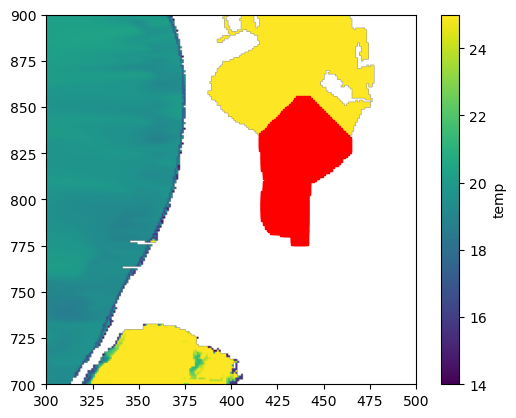

In [7]:
# Find the locations of NaN values
temp = ds.variables['temp'][:]
nan_locations = np.argwhere(np.isnan(np.squeeze(temp[-1,0,-1,:,:])))

# Extract row and column indices for plotting
row_indices = nan_locations[:, 0]
col_indices = nan_locations[:, 1]
fig, ax = plt.subplots()
im=ax.imshow(temp[-1,0,-1,:,:],  vmin=14, vmax=25 ,origin='lower') #, extent=[350, 450, 750, 850])
cbar = fig.colorbar(im, ax=ax, label='temp')
ax.scatter(col_indices, row_indices, color='red', marker='s', s=100, label='NaN Locations') # Plot NaN points
# Set x-axis limits from 2 to 8
plt.xlim(300, 500) 
# Set y-axis limits from -0.5 to 0.5
plt.ylim(700, 900) 


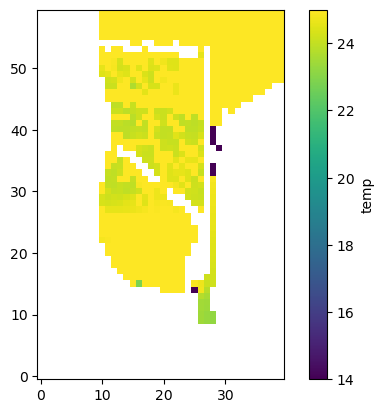

In [ ]:
fig, ax = plt.subplots()
temp = ds.variables['temp'][:]
im=ax.imshow(temp[7,1,-1,770:830,410:450],  vmin=14, vmax=25 ,origin='lower') #, extent=[350, 450, 750, 850])
cbar = fig.colorbar(im, ax=ax, label='temp')



In [23]:
fn_grid = '/scratch/PFM_Simulations/Grids/GRID_SDTJRE_LV4_mss_oct2024.nc'
dsg = nc.Dataset(fn_grid)



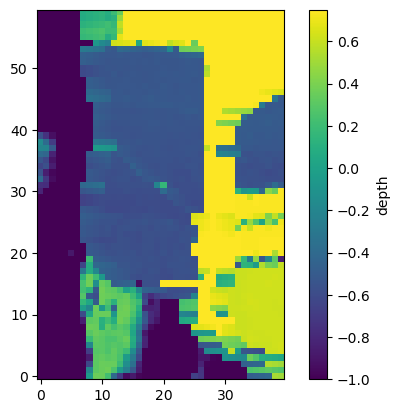

In [33]:
fig, ax = plt.subplots()
hb = dsg.variables['h'][:]
im=ax.imshow(hb[770:830,410:450] ,  vmin=-1, vmax=.75 , origin='lower') #, extent=[350, 450, 750, 850])
cbar = fig.colorbar(im, ax=ax, label='depth')
